In [12]:
import pandas as pd
import sys
import glob
import os

pd.set_option('display.max_columns', 100)
os.chdir('/home/jovyan/cpdb_tutorial')

In [2]:
print(sys.version)

3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]


In [ ]:
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [ ]:
# -- Version of the databse
cpdb_version = 'v4.1.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('/home/jovyan/cpdb_tutorial/db', cpdb_version)

In [ ]:
from cellphonedb.utils import db_utils

db_utils.download_database(cpdb_target_dir, cpdb_version)

In [3]:
cpdb_file_path = 'db/v4.1.0/cellphonedb.zip'
meta_file_path = '/lustre/scratch126/cellgen/team205/rl20/CTCL/cellphoneDB/CTCL_sub_nomore_100_per_donor_celltype_anno_meta.txt'
counts_file_path = '/lustre/scratch126/cellgen/team205/rl20/CTCL/cellphoneDB/CTCL_sub_nomore_100_per_donor_celltype_anno.h5ad'
#microenvs_file_path = 'data/microenvironment.tsv'
out_path = '/home/jovyan/farm/CTCL/cellphoneDB_4'

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,barcode_sample,cell_type
0,AAACCTGAGTTCGCAT-1,VE2
1,AAACCTGCACACCGCA-1,Undifferentiated_KC
2,AAACCTGTCGCGTTTC-1,Undifferentiated_KC


In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(32556, 33538)

In [6]:
list(adata.obs.index).sort() == list(metadata['barcode_sample']).sort()

True

In [7]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

deconvoluted, means, pvalues, significant_means = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellPhoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 4,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
/lustre/scratch126/cellgen/team205/rl20/CTCL/cellphoneDB/CTCL_sub_nomore_100_per_donor_celltype_anno.h5ad
/lustre/scratch126/cellgen/team205/rl20/CTCL/cellphoneDB/CTCL_sub_nomore_100_per_donor_celltype_anno_meta.txt
[ ][CORE][19/10/23-16:24:58][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:4 Precision:3
[ ][CORE][19/10/23-16:24:58][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][19/10/23-16:25:02][INFO] Running Real Analysis
[ ][CORE][19/10/23-16:25:02][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [10:43<00:00,  1.55it/s]


[ ][CORE][19/10/23-16:35:46][INFO] Building Pvalues result
[ ][CORE][19/10/23-16:35:54][INFO] Building results
Saved deconvoluted to /home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_deconvoluted_10_19_2023_16:35:54.txt
Saved means to /home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_means_10_19_2023_16:35:54.txt
Saved pvalues to /home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_pvalues_10_19_2023_16:35:54.txt
Saved significant_means to /home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_significant_means_10_19_2023_16:35:54.txt


In [10]:
import ktplotspy as kpy

In [20]:
adata = anndata.read_h5ad(counts_file_path)

In [29]:
adata.X

<32556x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 55136690 stored elements in Compressed Sparse Row format>

In [16]:
means = pd.read_csv("/home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_means_10_19_2023_16:35:54.txt", sep="\t")
pvals = pd.read_csv("/home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_pvalues_10_19_2023_16:35:54.txt", sep="\t")
decon = pd.read_csv("/home/jovyan/farm/CTCL/cellphoneDB_4/statistical_analysis_deconvoluted_10_19_2023_16:35:54.txt", sep="\t")

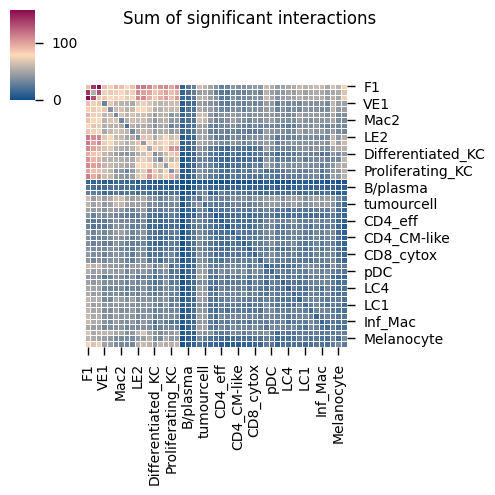

In [18]:
kpy.plot_cpdb_heatmap(pvals=pvals, figsize=(5, 5), title="Sum of significant interactions")